In [1]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(10,10)

import warnings
warnings.filterwarnings(action='ignore')
import time

from glob import glob
from tqdm import tqdm
from scipy import interpolate
from sklearn.preprocessing import RobustScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D 
from keras.callbacks import ModelCheckpoint, EarlyStopping

#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
## 1. 데이터 불러오기, 공통 전처리
raw_data = pd.read_csv('C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/rawdata.csv')


###유입량, 저수량 제거
raw_data_ = raw_data.drop(raw_data[['유입량','저수량','대곡교_강수량','진관교_강수량','송정동_강수량','청담대교_유량','잠수교_유량','한강대교_유량']], axis = 1)

###강화대교 조위 시간차
강화대교_조위 = pd.read_csv('C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/tide_level_all.csv', encoding='cp949')
raw_data__ = pd.concat((raw_data_.drop(강화대교_조위.columns,axis=1),강화대교_조위),axis=1)
raw_data___ = raw_data__.set_index('날짜',drop=True)

###보간 처리

보간처리 = raw_data___[['현재수위','공용량','방류량','강화대교_조위', '청담대교_수위', '잠수교_수위', '한강대교_수위', '행주대교_수위', '행주대교_유량']].interpolate(method = 'linear' , limit_direction = 'forward')
보간처리df = pd.concat([raw_data___.drop(보간처리.columns, axis = 1), 보간처리], axis=1)

input_y = 보간처리df[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x = 보간처리df.drop(input_y.columns, axis = 1)

## 정규화
from sklearn.preprocessing import StandardScaler

input_x_regular = input_x.copy()
input_y_regular = input_y.copy()



In [3]:
median_list = []
denominator_list = [] #q3 - q1

for i in range(4):
    median_list.append(np.median(input_y_regular[:269424].iloc[:,i]))
    q1 = np.quantile(input_y_regular[:269424].iloc[:,i], 0.25)
    q3 = np.quantile(input_y_regular[:269424].iloc[:,i], 0.75)
    denominator_list.append(q3 - q1)

print("1번 q2:", median_list[0])
print("1번 q3-q1:", denominator_list[0])

print("2번 q2:", median_list[1])
print("2번 q3-q1:", denominator_list[1])

print("3번 q2:", median_list[2])
print("3번 q3-q1:", denominator_list[2])

print("4번 q2:", median_list[3])
print("4번 q3-q1:", denominator_list[3])

1번 q2: 307.7
1번 q3-q1: 55.0
2번 q2: 297.2
2번 q3-q1: 51.0
3번 q2: 295.0
3번 q3-q1: 51.99999999999994
4번 q2: 286.3
4번 q3-q1: 48.99999999999994


In [4]:
for i in range(len(input_x.columns)):
    scaler = RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x
    
for i in range(len(input_y.columns)):
    scaler = RobustScaler()
    b=np.array(input_y_regular[:269424].iloc[:,i])
    tmp_y = scaler.fit_transform(b.reshape(-1,1))
    y_zeors = np.zeros(6912).reshape(-1,1)
    tmp_y=np.concatenate((tmp_y,y_zeors))
    input_y_regular.iloc[:,i] = tmp_y

input_regular = pd.concat([input_x_regular, input_y_regular], axis = 1)



#train / test data 생성

idx = []
for i in range(12):
  idx.append(i*26496)

In [5]:
input_regular

,현재수위,공용량,방류량,강화대교_조위,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,
2012-05-01 00:00,-1.428571,-0.082668,1.018831,-0.467577,-0.200895,0.054545,0.058824,-0.096154,-0.224490
2012-05-01 00:10,-1.457143,-0.070125,1.040010,-0.447099,-0.200895,0.127273,0.058824,-0.096154,-0.224490
2012-05-01 00:20,-1.480952,-0.061003,1.076203,-0.419795,-0.200895,0.109091,0.078431,-0.096154,-0.224490
2012-05-01 00:30,-1.480952,-0.061003,1.040546,-0.392491,-0.183595,0.072727,0.078431,-0.096154,-0.204082
2012-05-01 00:40,-1.480952,-0.061003,1.076203,-0.354949,-0.166109,0.072727,0.078431,-0.076923,-0.183673
...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10,-0.285714,0.271380,0.225881,0.262799,0.425595,0.000000,0.000000,0.000000,0.000000
2022-07-18 23:20,-0.285714,0.271380,0.229179,0.344710,0.472457,0.000000,0.000000,0.000000,0.000000
2022-07-18 23:30,-0.285714,0.271380,0.226257,0.419795,0.520098,0.000000,0.000000,0.000000,0.000000


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:48<00:00, 15.34s/it]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 287, 32)           352       
                                                                 
 dropout (Dropout)           (None, 287, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 12)           780       
                                                                 
 dropout_1 (Dropout)         (None, 286, 12)           0         
                                                                 
 flatten (Flatten)           (None, 3432)              0         
                                                                 
 dropout_2 (Dropout)         (None, 3432)              0         
                                                                 
 dense (Dense)               (None, 45)                1

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:52<00:00, 15.68s/it]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 287, 32)           352       
                                                                 
 dropout_3 (Dropout)         (None, 287, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 286, 12)           780       
                                                                 
 dropout_4 (Dropout)         (None, 286, 12)           0         
                                                                 
 flatten_1 (Flatten)         (None, 3432)              0         
                                                                 
 dropout_5 (Dropout)         (None, 3432)              0         
                                                                 
 dense_2 (Dense)             (None, 45)               

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:06<00:00,  6.02s/it]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 287, 32)           352       
                                                                 
 dropout_6 (Dropout)         (None, 287, 32)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 286, 12)           780       
                                                                 
 dropout_7 (Dropout)         (None, 286, 12)           0         
                                                                 
 flatten_2 (Flatten)         (None, 3432)              0         
                                                                 
 dropout_8 (Dropout)         (None, 3432)              0         
                                                                 
 dense_4 (Dense)             (None, 45)               

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:15<00:00, 12.36s/it]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 287, 32)           352       
                                                                 
 dropout_9 (Dropout)         (None, 287, 32)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 286, 12)           780       
                                                                 
 dropout_10 (Dropout)        (None, 286, 12)           0         
                                                                 
 flatten_3 (Flatten)         (None, 3432)              0         
                                                                 
 dropout_11 (Dropout)        (None, 3432)              0         
                                                                 
 dense_6 (Dense)             (None, 45)               

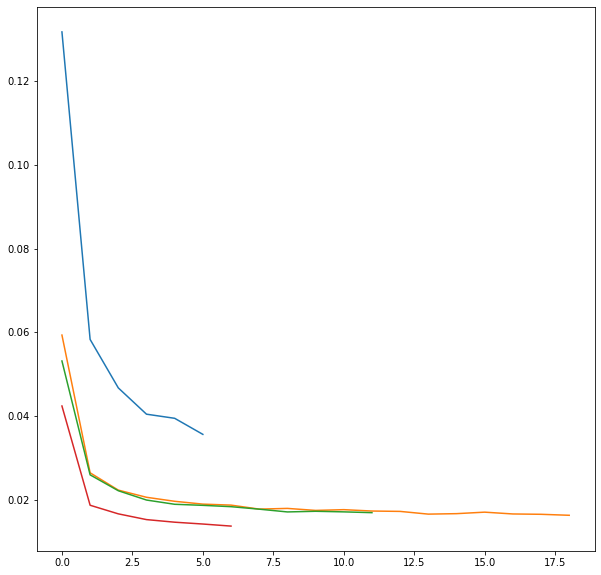

time : 6505.54677772522 초


In [6]:
start = time.time()

y_predict = []

for k in range(4,8):
    xdata = []
    ydata = []
    num = 0
    w =  288 #window size

    for i in tqdm(range(11)):
        if i != 10:
          tmp = input_regular[idx[i]:idx[i+1]]
        else:
          tmp = input_regular[idx[i]:]

        for j in range(len(tmp)-w+1):
            xdata.append(np.array(tmp.iloc[j:j + w, [0,1,2,3,4]]).astype(float))

        for j in range(w-1,len(tmp)):
            ydata.append(np.array(tmp.iloc[j, k]).astype(float)) #4, 5, 6, 7 넣기

    xdata_ = np.array(xdata)
    ydata_ = np.array(ydata)

    xtrain = xdata_[:266267]
    ytrain = ydata_[:266267]
    xtest = xdata_[266267:]
    ytest = ydata_[266267:]


    # 모델링 및 모델 학습

    # !pip install keras 

    """ KERAS IMPLEMENTATION """

    # Research on parameter : Dilation_Rate of the convolution 
    if 'model' in locals(): 
        del model 
    if 'history' in locals():
        del history

    model = Sequential()
    model.add(Conv1D(filters = 32,
                    input_shape = (w, len(input_x_regular.columns)),
                    data_format = 'channels_last',
                    kernel_size = 2,
    #                 strides = (1,1),
                    activation = 'relu'))
    # model.add(MaxPooling1D(pool_size=2)) ?? 
    # model.add(AveragePooling1D(pool_size=2)) ?? 
    model.add(Dropout(0.2))

    model.add(Conv1D(filters = 12,
                    data_format = 'channels_last',
                    kernel_size = 2,
    #                 strides = (1,1),
                    activation = 'relu'))
    # model.add(MaxPooling1D(pool_size=2)) ?? 
    # model.add(AveragePooling1D(pool_size=2)) ?? 

    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(45, activation = 'relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()



    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=5),
                 keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                 monitor='val_loss',
                                                 save_best_only=True)]

    history = model.fit(xtrain, ytrain, epochs=300, verbose=1, validation_split=0.2, callbacks=callbacks) #기본은 500
    plt.plot(history.history['loss'])

    keras_model_best = keras.models.load_model('best_model.h5')

    keras_model_best.evaluate(xtest,ytest)

    y_predict.append(keras_model_best.predict(xtest) * denominator_list[k-4] + median_list[k-4])
 
    print("="*120)
    print("="*120)

plt.show()

print("time :", time.time() - start, "초")

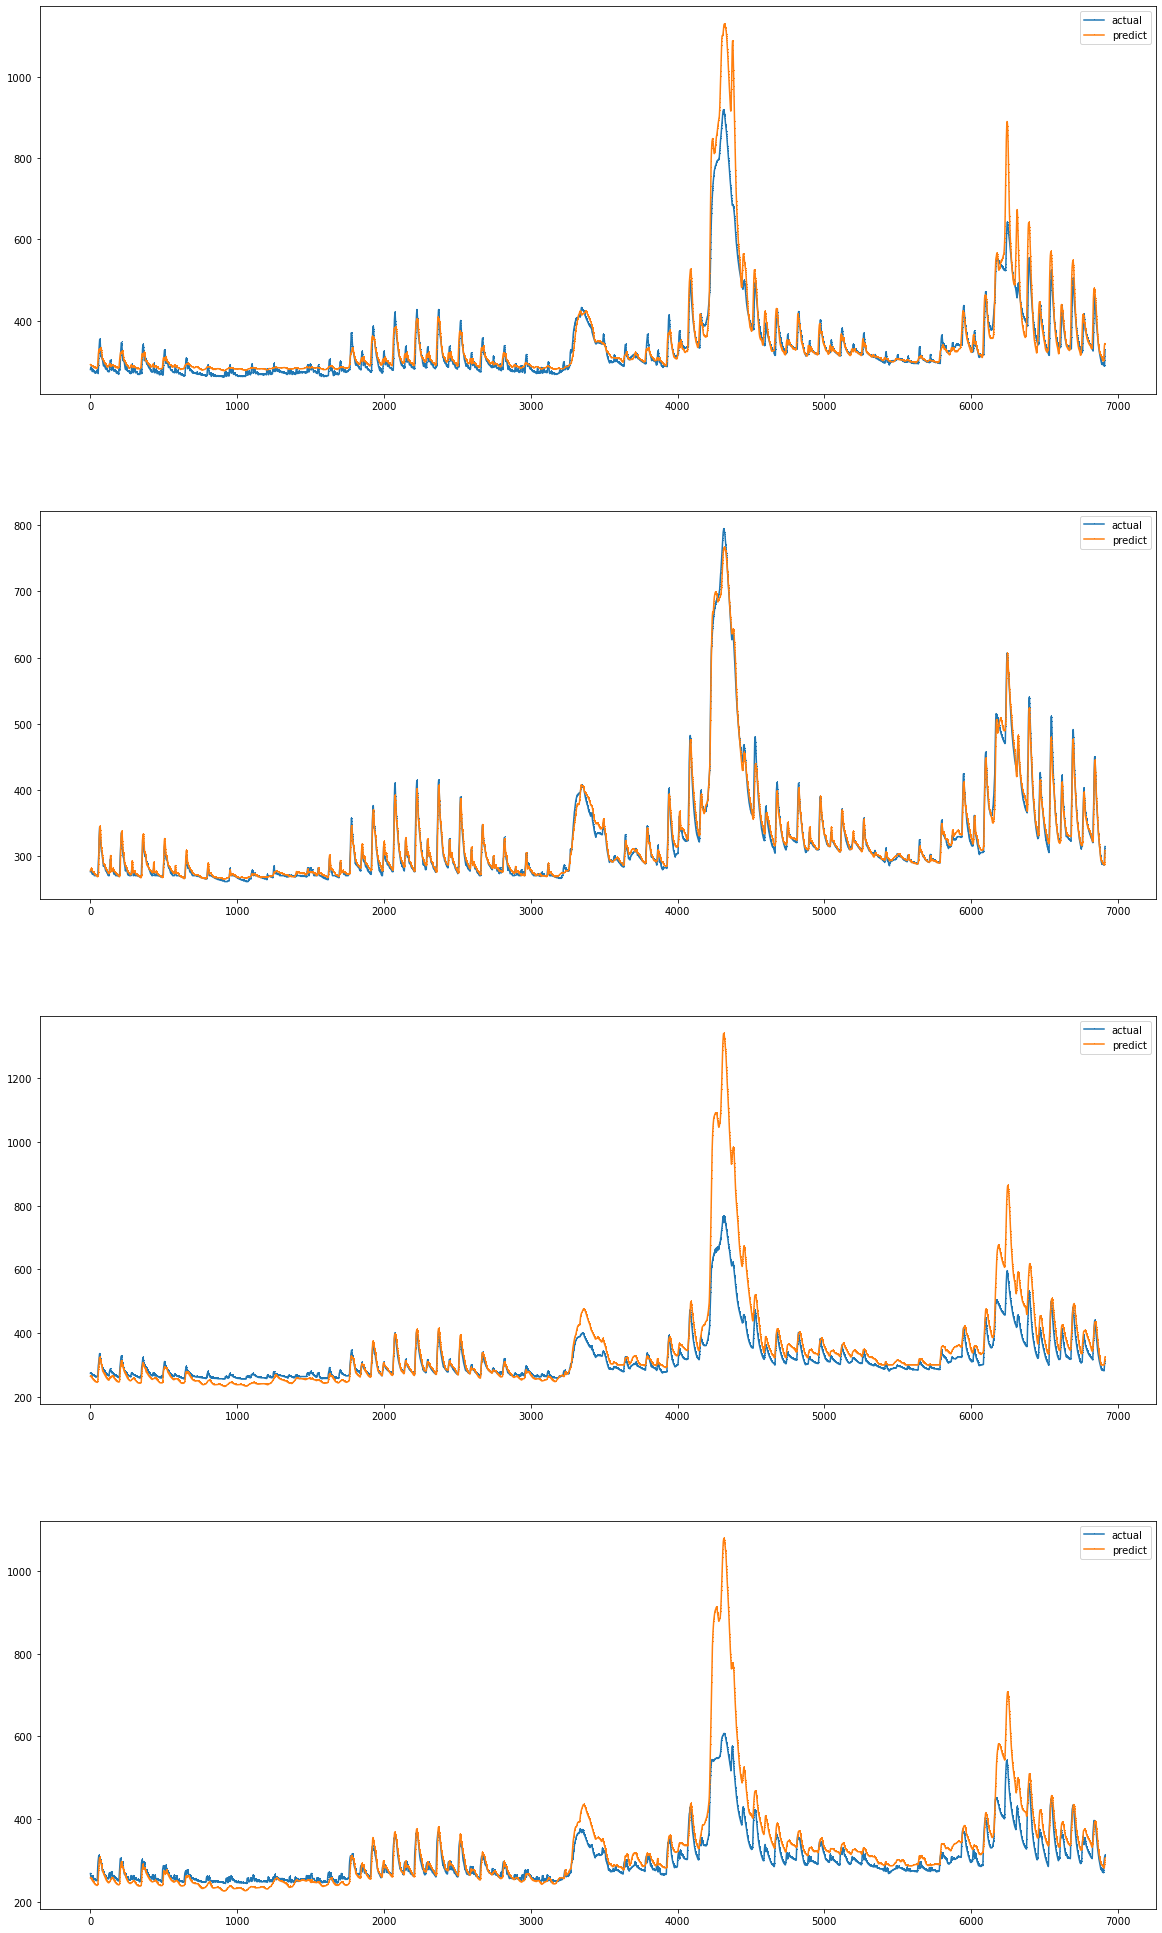

In [7]:
ytest_list = sorted(glob("C:/Users/sjkan/Desktop/submission 임시/*.csv"))

ytest = []

for i in range(len(ytest_list)):
  tmp = pd.read_csv(ytest_list[i], encoding = 'cp949')
  ytest.append(np.array(tmp.iloc[:,1])*100)

f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest[i], marker = ",", label = "actual")     
    axes[i].plot(y_predict[i], marker = ",", label="predict")  #모델 결과값 리스트 : y_predict[(청담 결과 array),[잠수 결과 array],[한강 결과 array],[행주 결과 array]]
    axes[i].legend(prop={'size':10})  

plt.show()

In [8]:
#제출 파일 생성

sample_submission = pd.read_csv("C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/sample_submission.csv")

sample_submission["wl_1018662"] = y_predict[0]
sample_submission["wl_1018680"] = y_predict[1]
sample_submission["wl_1018683"] = y_predict[2]
sample_submission["wl_1019630"] = y_predict[3]

sample_submission.to_csv("conv1d_robust.csv", index = False)